## Training a Unet

In this notebook, we will train a 2D U-net for nuclei segmentation in the Kaggle Nuclei dataset.

This notebook was inspired from the EMBL notebooks from the Kreshuk lab (https://github.com/kreshuklab/teaching-dl-course-2020/).

## The libraries

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import os
import datetime
import sys
import random
import warnings
import glob

import numpy as np
import pandas as pd
import imageio

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf


## Data loading and preprocessing

For this exercise we will be using the Kaggle 2018 Data Science Bowl data again, but this time we will try to segment it with the state of the art network.
Let's start with loading the data as before.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EbvS10-83JGNE2nlBxIV42izY1TOr115' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1EbvS10-83JGNE2nlBxIV42izY1TOr115" -O kaggle_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq kaggle_data.zip && rm kaggle_data.zip

--2021-05-25 15:11:31--  https://docs.google.com/uc?export=download&confirm=rP1t&id=1EbvS10-83JGNE2nlBxIV42izY1TOr115
Resolving docs.google.com (docs.google.com)... 142.250.65.78, 2607:f8b0:4004:82a::200e
Connecting to docs.google.com (docs.google.com)|142.250.65.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-80-docs.googleusercontent.com/docs/securesc/uiv4vvpv4577gn56vpag6griqdgnd7al/jvruhs3537edra4kcfqfjefjrq4tfmek/1621955475000/17999766797462482814/17711044171886110657Z/1EbvS10-83JGNE2nlBxIV42izY1TOr115?e=download [following]
--2021-05-25 15:11:31--  https://doc-10-80-docs.googleusercontent.com/docs/securesc/uiv4vvpv4577gn56vpag6griqdgnd7al/jvruhs3537edra4kcfqfjefjrq4tfmek/1621955475000/17999766797462482814/17711044171886110657Z/1EbvS10-83JGNE2nlBxIV42izY1TOr115?e=download
Resolving doc-10-80-docs.googleusercontent.com (doc-10-80-docs.googleusercontent.com)... 142.251.33.193, 2607:f8b0:4004:837::2001
Connecting to doc-10-

If everything went fine, you should have folders `nuclei_train_data` and `nuclei_val_data` in your working directory. Check if it is the case by running the following cell. You should have two folders :
- nuclei_train_data
- nuclei_val_data

In [ ]:
!ls -l

total 88
drwxr-xr-x 538 root root 61440 Dec 13  2019 nuclei_train_data
drwxr-xr-x 136 root root 20480 Dec 13  2019 nuclei_val_data
drwxr-xr-x   1 root root  4096 May  6 13:44 sample_data


As an example, few images are randomly displayed below (raw image and the associated mask). Note that for each mask, only one object is displayed.

In [ ]:
def show_one_image(image_path):
  image = imageio.imread(image_path)
  plt.imshow(image)

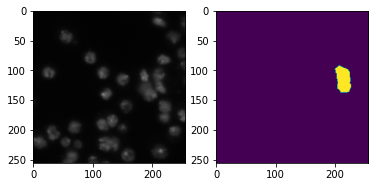

In [ ]:
list_dir = glob.glob('nuclei_train_data/*')
num = random.randint(0, len(list_dir))

plt.subplot(1,2,1)
im_path = list_dir[num]
list_im = glob.glob(im_path + '/images/*png')
show_one_image(list_im[0])

plt.subplot(1,2,2)
im_path = list_dir[num]
list_im = glob.glob(im_path + '/masks/*png')
show_one_image(list_im[1])
    

What one would normally start with in any machine learning pipeline is writing a dataset - a class that will fetch the training samples. In the previous exercises we did not have to worry about it, since we used the classic datasets available in the torchvision library. However, once you switch to using your own data, you would have to figure out how to fetch the data yourself. Luckily most of the functionality is already provided, but what you need to do is to write a class, that will actually supply the dataloader with training samples - a Dataset.

For this exercise you will not have to do it yourself yet, but please carefully read through the provided class:

In [ ]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'nuclei_train_data/'
TEST_PATH = 'nuclei_val_data/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [ ]:
def get_data(path, train=True):
  # get the total number of samples
  ids = next(os.walk(path))[1]
  X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
  Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  print('Getting and resizing train images and masks ... ')
  sys.stdout.flush()
  for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    path_new = path + id_
    # we'll be using skimage library for reading file
    img = imread(path_new + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    # masks directory has multiple images - one mask per nucleus
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path_new + '/masks/'))[2]:
        mask_ = imread(path_new + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask
  if train:
    return X, Y
  else:
    return X

Now let's load the dataset and visualize it by calling our function:

In this example, we read all images of the train folder as training data (applied SGD on) and all images of the validation folder for testing data (report performance on). Validation data (optimize hyper-parameters on) will be taken randomly from training data during the training process.

In [ ]:
X_train, Y_train = get_data(TRAIN_PATH, train=True)
X_test, Y_test = get_data(TEST_PATH, train=True)

X_train = X_train/255
X_test = X_test/255

Getting and resizing train images and masks ... 


100%|██████████| 536/536 [03:41<00:00,  2.42it/s]

Getting and resizing train images and masks ... 



100%|██████████| 134/134 [01:03<00:00,  2.11it/s]


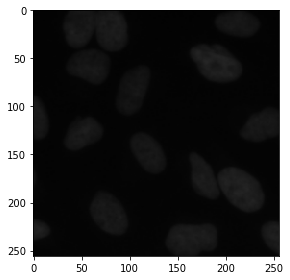

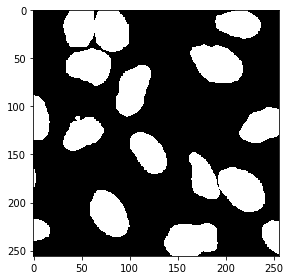

In [ ]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Building a U-NET model
Now we need to define the architecture of the model to use. This time we will use a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) that has proven to steadily outperform the other architectures in segmenting biological and medical images. See also this [link](https://towardsdatascience.com/u-net-b229b32b4a71) for a discussion regarding the intuition behind the Unet.

The U-net has an encoder-decoder structure: 

In the encoder pass, the input image is successively downsampled via max-pooling. In the decoder pass it is upsampled again via [transposed convolutions](https://towardsdatascience.com/transposed-convolution-demystified-84ca81b4baba).

In adddition, it has skip connections, that bridge the output from an encoder to the corresponding decoder.

Note that we are using valid convolutions here; the input to convolutions are not padded and the spatial output size after applying them decreases. Hence, the spatial output size of the network will be smaller than the spatial input size. This could be avoided by using same convolutions, which would increase the computational effort though.

Compared to the paper, we will use less features (channels) to enable training the network on the CPU as well.

In [ ]:
#Each block of u-net architecture consist of two Convolution layers
# These two layers are written in a function to make our code clean
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(input_tensor)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
               padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    # x = Dropout(rate=dropout_rate)(x)
    return x

In [ ]:
# The u-net architecture consists of contracting and expansive paths which
# shrink and expands the inout image respectivly. 
# Output image have the same size of input image
def get_unet(input_img, n_filters):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*4, kernel_size=3) #The first block of U-net
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*8, kernel_size=3)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*16, kernel_size=3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*32, kernel_size=3)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = conv2d_block(p4, n_filters=n_filters*64, kernel_size=3)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)
    
    c6 = conv2d_block(p5, n_filters=n_filters*128, kernel_size=3) # last layer on encoding path 
    
    # expansive path
    u7 = Conv2DTranspose(n_filters*64, (3, 3), strides=(2, 2), padding='same') (c6) #upsampling included
    u7 = concatenate([u7, c5])
    c7 = conv2d_block(u7, n_filters=n_filters*64, kernel_size=3)
    # c7 = Dropout(0.4) (c7)

    u8 = Conv2DTranspose(n_filters*32, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c4])
    c8 = conv2d_block(u8, n_filters=n_filters*32, kernel_size=3)
    # c8 = Dropout(0.35) (c8)

    u9 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c3])
    c9 = conv2d_block(u9, n_filters=n_filters*16, kernel_size=3)
    # c9 = Dropout(0.3) (c9)

    u10 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c9)
    u10 = concatenate([u10, c2])
    c10 = conv2d_block(u10, n_filters=n_filters*8, kernel_size=3)
    # c10 = Dropout(0.25) (c10)

    u11 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = conv2d_block(u11, n_filters=n_filters*4, kernel_size=3)
    # c11 = Dropout(0.2) (c11)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c11)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## Loss and distance metrics

The next step to do would be writing a loss function - a metric that will tell us how close we are to the desired output. This metric should be differentiable, since this is the value to be backpropagated. The are [multiple losses](https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/) we could use for the segmentation task.

Take a moment to think which one is better to use. If you are not sure, don't forget that you can always google! Before you start implementing the loss yourself, take a look at the [losses](https://keras.io/losses/) already implemented in Keras. You can also look for implementations on GitHub.

We use Binary Cross Entropy averaged over pixels as training loss.
This loss function is similar to the cross entropy loss we have used
for the previous classification tasks.

The difference to these tasks is that we predict a single number per pixel
(the probability of this pixel being foreground / background) instead of 
a vector per image that encodes the probabilities for several classes.

We also will use the [Dice Coefficeint](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to evaluate the network predictions.
We can use it for validation if we interpret set $a$ as predictions and $b$ as labels. It is often used to evaluate segmentations with sparse foreground, because the denominator normalizes by the number of foreground pixels.
The Dice Coefficient is closely related to Jaccard Index / Intersection over Union.

In [ ]:
# the coefficient takes values in [0, 1], where 0 is the worst score, 1 is the best score
# the dice coefficient of two sets represented as vectors a, b ca be computed as (2 *|a b| / (a^2 + b^2))
def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + eps)

def loss_dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = float(y_true_f)
    y_pred_f = float(y_pred_f)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + eps)

In [ ]:
# Creating and Compiling the model
input_img = Input((X_train.shape[1], X_train.shape[2], 3), name='img')
model = get_unet(input_img, n_filters=4)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[dice_coefficient])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
# saving the log and show it by tensorboard

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

%tensorboard --logdir logs

In [ ]:
# Fiting the model - Note that the validation_split option is used to split the training
# data into training and validation. Here 70% of the training data are used for 
# training, the other 30% for the validation.

# datagen = ImageDataGenerator(vertical_flip=True, horizontal_flip=True)
# it_train = datagen.flow(X_train, Y_train, batch_size=16)
# steps = int(X_train.shape[0] / 16)

# results = model.fit_generator(it_train,
#                     steps_per_epoch=steps, epochs=100,
#                     callbacks=[tensorboard_callback],
#                     validation_data=(X_test, Y_test))

results = model.fit(X_train, Y_train, 
                    batch_size=16, epochs=100, 
                    callbacks=[tensorboard_callback],
                    validation_split=0.3)

Epoch 1/100
24/24 [==============================] - 47s 389ms/step - loss: 0.6207 - dice_coefficient: 0.5477 - val_loss: 0.5430 - val_dice_coefficient: 0.3511
Epoch 2/100
24/24 [==============================] - 5s 191ms/step - loss: 0.3974 - dice_coefficient: 0.7091 - val_loss: 5.8710 - val_dice_coefficient: 0.2206
Epoch 3/100
24/24 [==============================] - 5s 192ms/step - loss: 0.3543 - dice_coefficient: 0.7429 - val_loss: 0.4887 - val_dice_coefficient: 0.3794
Epoch 4/100
24/24 [==============================] - 5s 192ms/step - loss: 0.2584 - dice_coefficient: 0.8064 - val_loss: 0.4266 - val_dice_coefficient: 0.3524
Epoch 5/100
24/24 [==============================] - 5s 193ms/step - loss: 0.2052 - dice_coefficient: 0.8611 - val_loss: 0.4156 - val_dice_coefficient: 0.2645
Epoch 6/100
24/24 [==============================] - 5s 195ms/step - loss: 0.1631 - dice_coefficient: 0.8924 - val_loss: 0.4187 - val_dice_coefficient: 0.2413
Epoch 7/100
24/24 [==========================

## Model testing and predictions
Now this is the time to evaluate our training model on test data which the model has never seen them before. In Keras, we can use "model.evaluate" to evaluate the training model where there is an avalibility of masks of test data.

In [ ]:
model.evaluate(X_test,Y_test)

5/5 [==============================] - 4s 333ms/step - loss: 0.0608 - dice_coefficient: 0.9409


[0.060761842876672745, 0.9409364461898804]

In Keras, "model.predict" is the function to predict output (masks in segmentation task or labels in classification task). Then we visualize results and visually compare the predicted masks with the ground truth.

In [ ]:
preds_test = model.predict(X_test, verbose=1)
# we apply a threshold on predicted mask (probability mask) to convert it to a binary mask.
preds_test_t = (preds_test > 0.7).astype(np.uint8) 

5/5 [==============================] - 1s 122ms/step


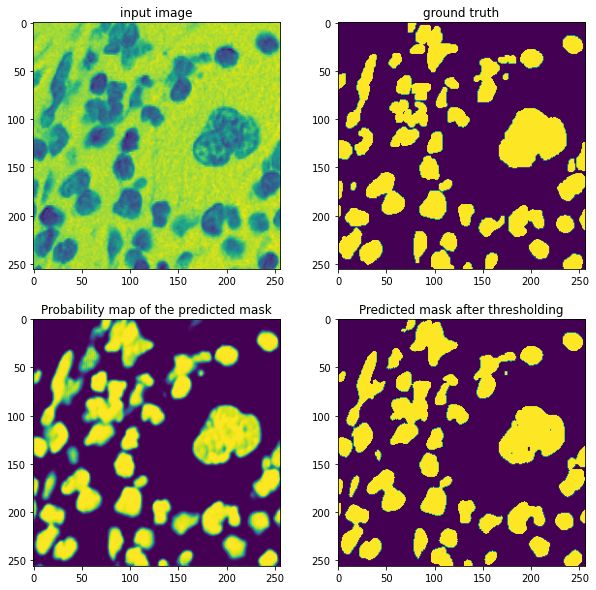

In [ ]:
ix = random.randint(0, len(X_test))
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(X_test[ix,:,:,0])
plt.title("input image")
plt.subplot(222)
plt.imshow(np.squeeze(Y_test[ix, :, :, 0]))
plt.title("ground truth")
plt.subplot(223)
plt.imshow(np.squeeze(preds_test[ix, :, :, 0]))
plt.title("Probability map of the predicted mask")
plt.subplot(224)
plt.imshow(np.squeeze(preds_test_t[ix, :, :, 0]))
plt.title("Predicted mask after thresholding")
# show the plot
plt.show()